# Clustering Project

This project will focus on unsupervised learning via clustering, kernel density estimation, and similar methods.  These are unsupervised learning methods: rather than a model learning to "predict Y from X," clustering and unsupervised models try to identify natural structures in the data.

We're going to use the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).  This is a decently large, and very high-dimensional dataset (784 dimensions) containing pictures of different clothing items.  The dataset contains a pre-made training and testing split; we're only going to use the testing split.  (some of the code in this notebook will take an absurd amount of time to run on the larger training set).

In [1]:
# Download and open the data if it isn't already on the local machine.
import gzip
import os
import requests

import numpy as np

if not os.path.isdir("fashion_mnist"):
    os.mkdir("fashion_mnist")
    
if not os.path.isfile("fashion_mnist/images.gz"):
    from_web = requests.get("http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz").content
    with open("fashion_mnist/images.gz", "wb") as OUT: OUT.write(from_web)
    
if not os.path.isfile("fashion_mnist/labels.gz"):
    from_web = requests.get("http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz").content
    with open("fashion_mnist/labels.gz", "wb") as OUT: OUT.write(from_web)
    
image_labels = np.frombuffer(
    gzip.open("fashion_mnist/labels.gz", "rb").read(),
    dtype=np.uint8,
    offset=8,
)
image_data = np.frombuffer(
    gzip.open("fashion_mnist/images.gz", "rb").read(),
    dtype=np.uint8,
    offset=16,
).reshape(len(image_labels), 784)

print(image_data.shape)

(10000, 784)


# Clustering in scikit-learn

Scikit-learn has implementations of three major clustering algorithms:
- K-Means
- Hierarchical/agglomerative clustering
- DBSCAN

Unlike with classification and regression models, I will go into the details of these a bit, because the differences matter a lot more than with most classification/regression models.  And because clustering models aren't usually as varied as classification and regression models.

## K-means

K-Means is not really a clustering algorithm.  It's a *spatial partitioning* algorithm, because it *partitions* the entire space into discrete bins.  It works like this:
1. Tell it the number of clusters you want to find.
2. K-Means will pick that many points, at random, somewhere in the general vicinity of your data.  These are the *cluster centroids*.
3. Repeat the following steps until convergence:
    a. For each observation in your dataset, assign it to a cluster based on which of the cluster centroids the observation is closest to.
    b. Update the cluster centers: the new location is the average of all points currently assigned to that cluster.
4. Now, the "cluster" of every point in space is whichever of your random points it's closest to.

Some important properties of K-Means:
- It assumes your cluster are generally convex shapes, and are roughly the same size (though this assumption is not very strong, e.g., if clusters are far apart).
- It assumes that your clusters have hard borders: you're either in a cluster or you're not, and you can onyl be in one.
- It assigns _every point in space_ to one of the clusters.  This can be problematic, but it's also a problem with nearly every model (clustering, classification, regression, statistical, etc).
- It is useful for dimensionality reduction: replacing each observation's features with the distance to each cluster center can be a pretty useful, and sensible, way to do dimensionality reduction/feature transformations.
- It tends to scale very well to extremely large datasets with lots of features; it's fast.

## Agglomerative/Hierarchical Clustering

Hierarchical Clustering (scikit-learn calls it *agglomerative* clustering) is probably the most common kind of clustering after K-Means.  It works roughly as follows:
1. Each point is assigned to its own cluster.
2. Repeat the following until there is onyl one cluster left:
    a. Merge pairs of clusters together.  Pairs are selected based on the *linkage* criterion, which the user can specify.

By keeping track of what gets merged with what, you can get a hierarchical relationship between clusters, which is often displayed in a *dendrogram.*  Some properties of hierarchical clustering:
- It tends to be pretty easy to interpret, and easy to tweak the results after the fact if they don't make a lot of sense.
- The different linkage criteria can make it quite flexible.  But, selecting the right linkage is critical, since they can behave very differently.  E.g., some linkages will result in fairly even cluster sizes, while others will result in very uneven sizes.
- It can't directly identify outlier points--every point is assigned to a cluster at every stage--but sometimes they can be spotted in the dendrogram.
- It scales *very* poorly to large datasets.  So much so that we're not actually going to run it on the Fashion MNIST data.

## (H)DBSCAN

DBSCAN/HDBSCAN are *density-based* clustering algorithms: a cluster is defined as a region of of high density surrounded by a region of low density.  That's it.  The details of how these algorithms work is a lot more complex (and I don't 100% understand all of it), so I won't go over "how it works" here.

Some properties of DBSCAN/HDBSCAN:
- *Soft clustering.*  A point can have *degrees of membership* in different clusters.
- No assumption on cluster size or shape.
- You do not specify the number of clusters; the algorithm determines that based on the other parameters you specify.
- Can automatically identify *noise* points (a more general notion of *outliers*; it's not just points that have extreme values, but any point that appears in a region of very low density).
- Tends to be slower than K-Means or hierarchical clustering.

DBSCAN has some stricter assumptions than HDBSCAN--mostly around cluster density (clusters are assumed to be roughly constant density), size, separation, etc.  HDBSCAN relaxes a lot of these assumptions and, as a result, tends to give much richer and more sensible results.

Scikit-learn doesn't have an implementation of HDBSCAN--it does have one for regular DBSCAN--so well install HDBSCAN.  (fun fact: it's made by the same people who made UMAP!)

```bash
conda install -c conda-forge hdbscan
```

# Some general notes on clustering

Clustering in high dimensions is generally a bad idea.  While we can still calculate things like "distance" in arbitrarily high dimensional space, none of our intuitions about distance and groupings will work.  It is an alien world, wholly unlike our own.  It's often a good idea to run PCA/SVD/UMAP to reduce your data down to a smaller dimensional space *before* clustering, which I'll be doing.

The Digits data from scikit-learn is fairly low-dimensional (only 64 dimensions).  I don't expect huge issues with clustering in 64 dimensions, but since we have the ground truth labes for the different images, we can test this!

Here's how we're going to proceed:
1. I'm going to run UMAP to get the data into 2d, so we can plot it.
2. I'm going to K-Means and HDBSCAN with reasonable settings (based on my previous experiences using them).  I'll run these in both the 2d and the 784d data.  I'll also use PCA to reduce the dimensionality of the data down while preserving 90% of the original variance.
3. I'll plot all the results, and compare with the ground truth labels.
4. I'll calculate the Rand Score for each clustering: this is a way of comparing cluster labels to ground-truth scores.  Higher is better.

In [2]:
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from umap import UMAP

def plot(points, ground_truth, cluster_labels, title):
    """Re-usable function to plot the results of a cluster analysis."""
    fig, ax = plt.subplots(ncols=2, figsize=(35,20))
    fig.suptitle(title, fontsize=40)
    ax[0].scatter(
        points[:,0],
        points[:,1],
        c=cluster_labels,
        cmap="tab20"
    )
    ax[0].set_title(title, fontsize=20)
    ax[1].scatter(
        points[:,0],
        points[:,1],
        c=ground_truth,
        cmap="tab20"
    )
    ax[1].set_title("Ground Truth", fontsize=20)
    plt.show()
    
plottable = UMAP(n_components=2).fit_transform(image_data)

CPU times: total: 29.5 s
Wall time: 5.44 s


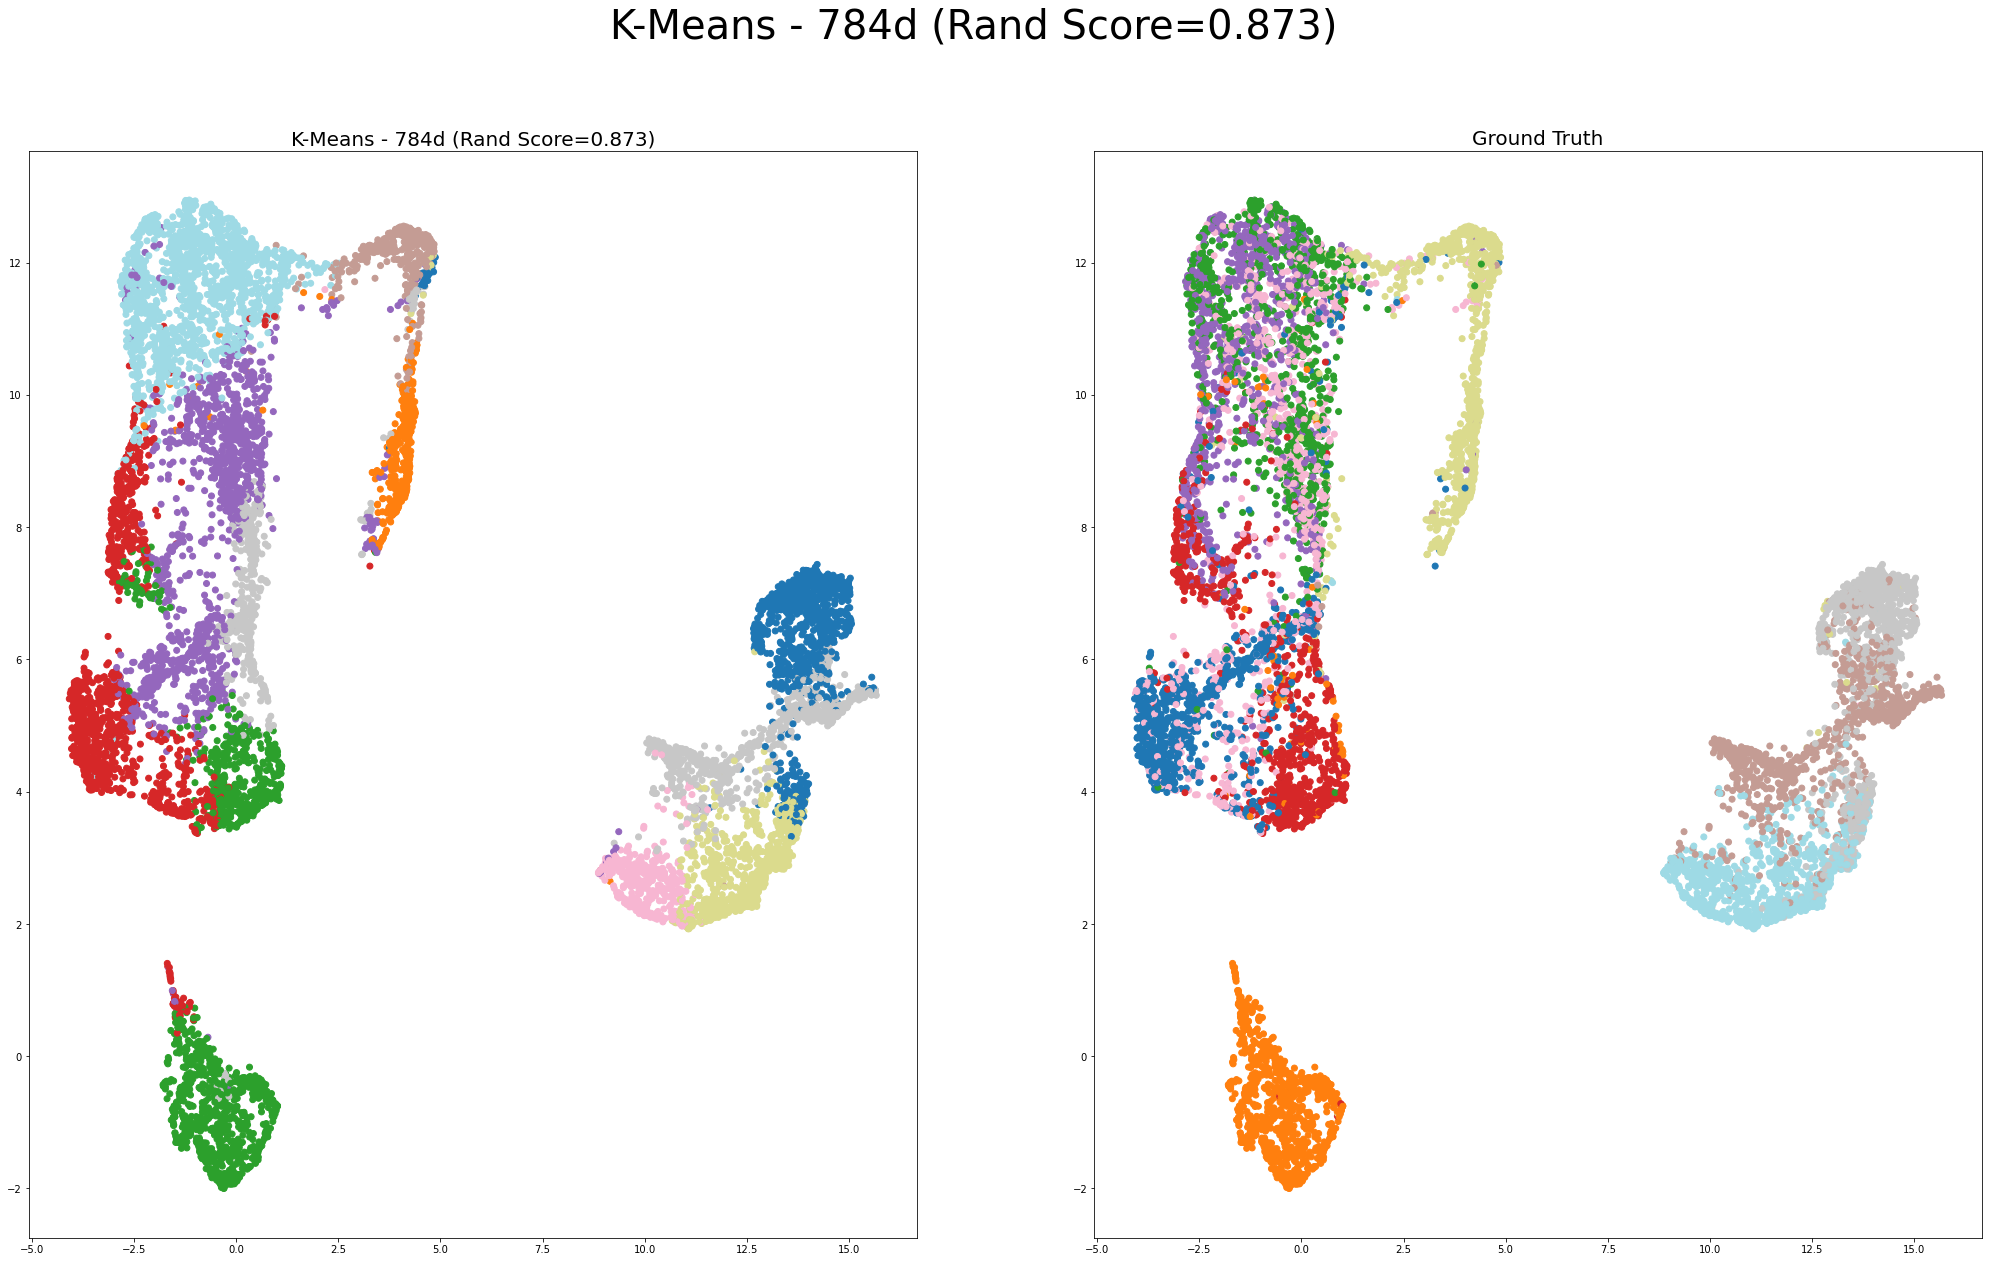

CPU times: total: 14.6 s
Wall time: 1.92 s


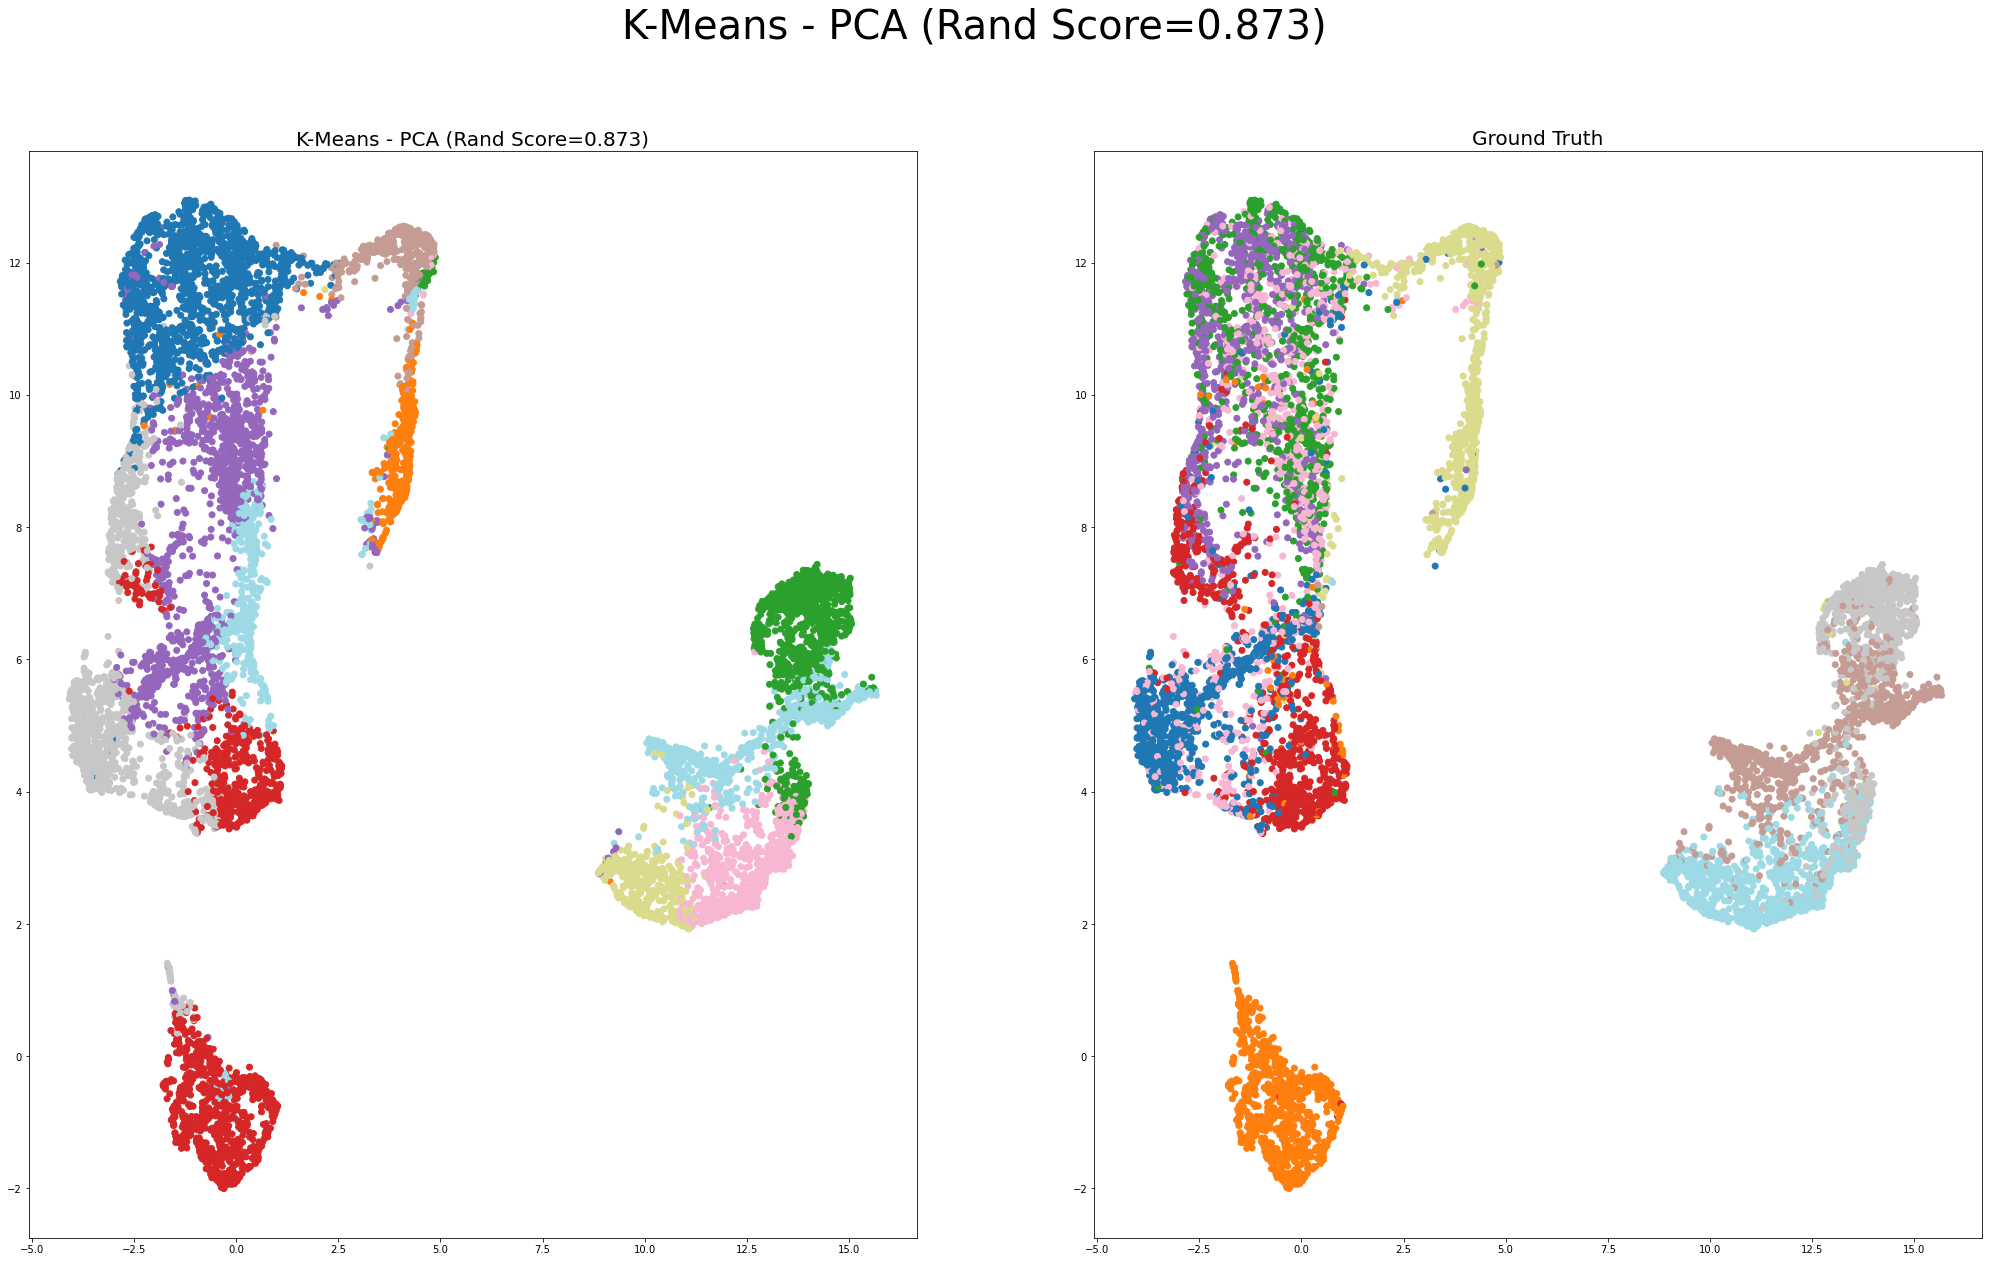

CPU times: total: 2.42 s
Wall time: 254 ms


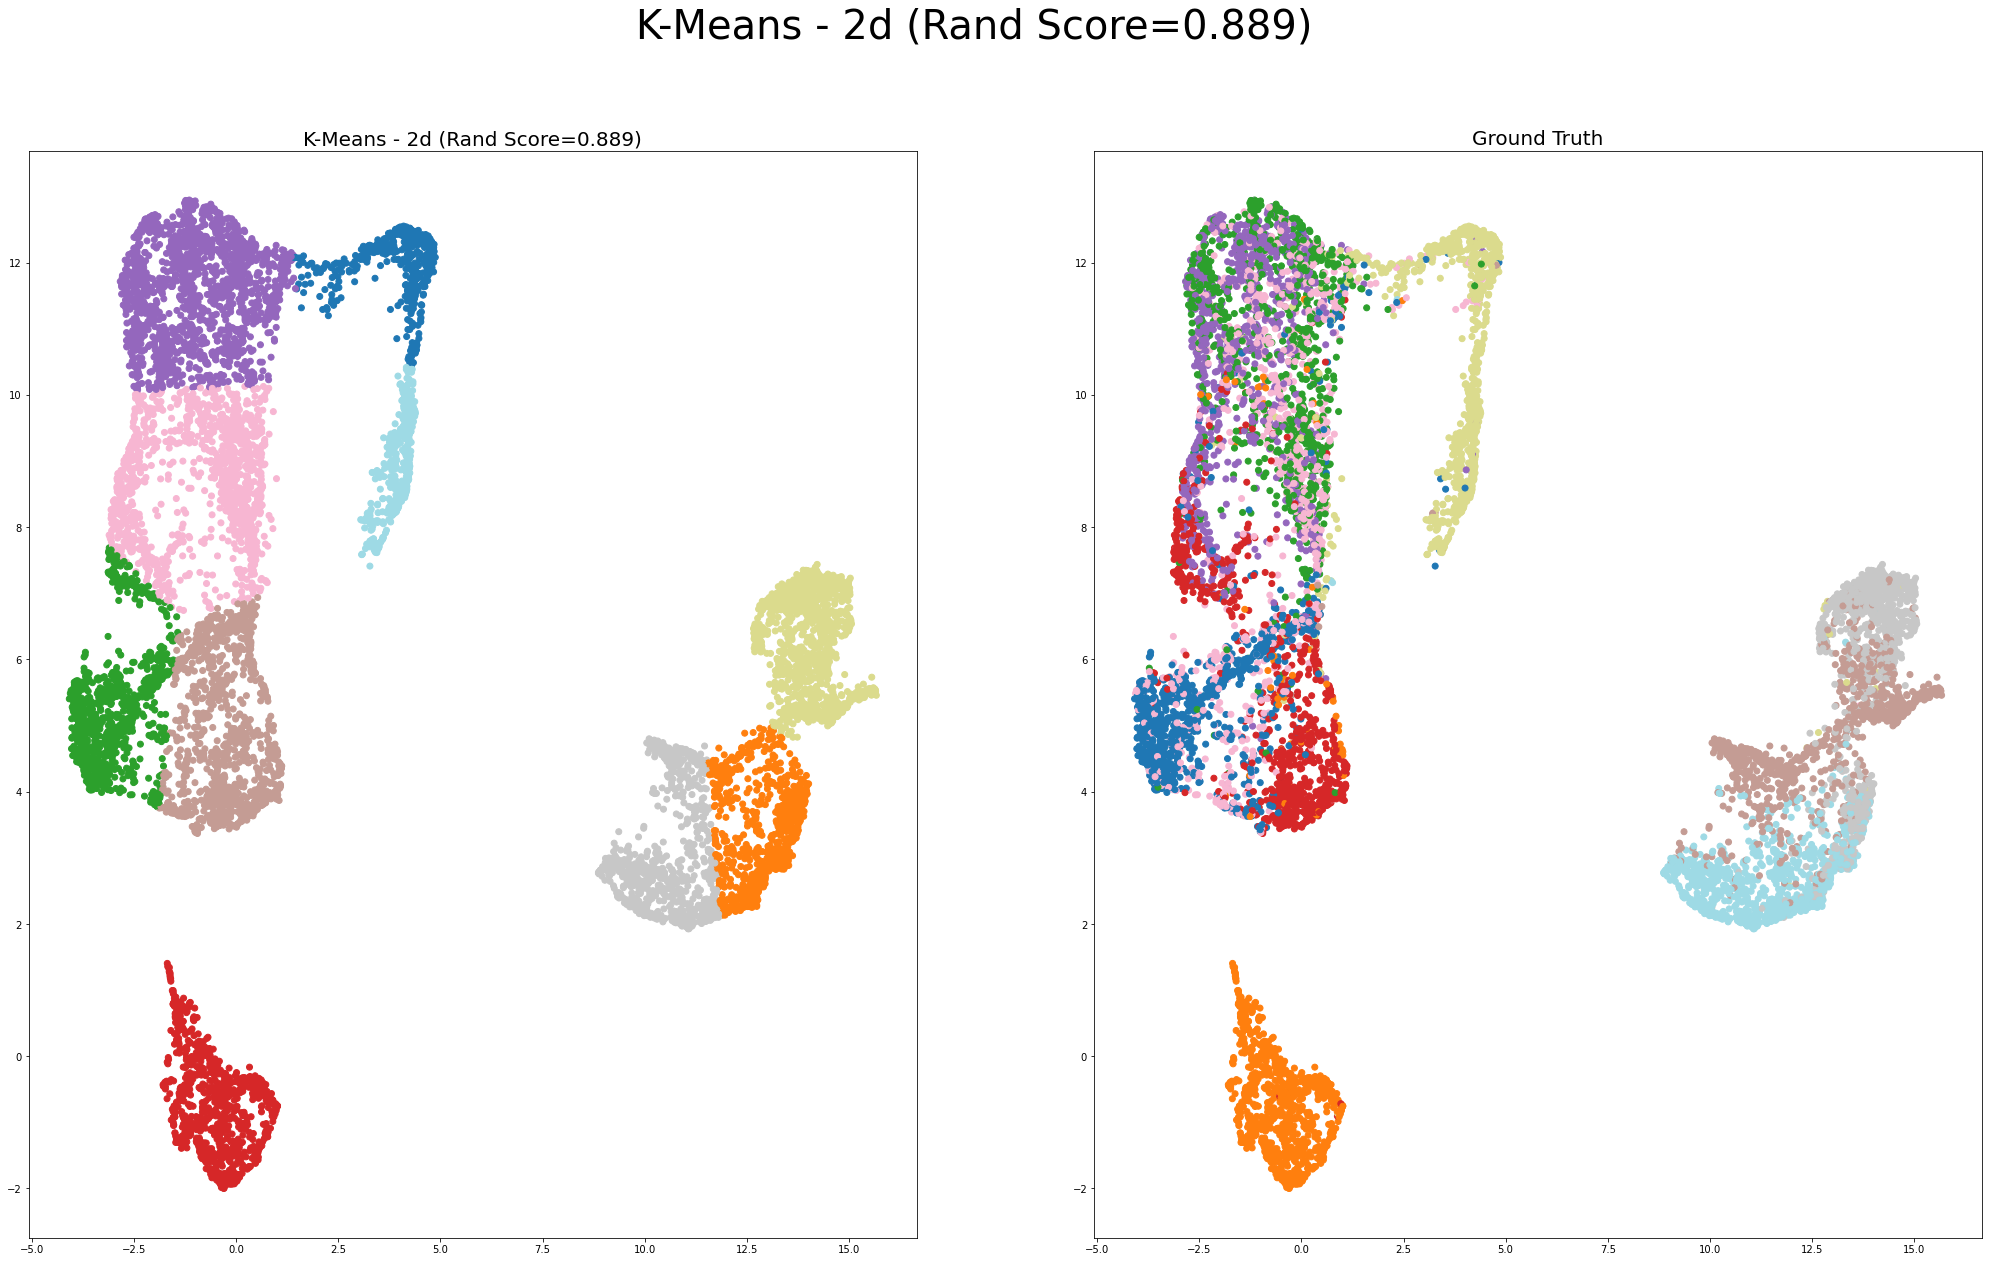

In [3]:
from sklearn.decomposition import PCA
# K-Means, orginal dimension.
# .fit_predict() is common on clustering algorithms;
# it's the equivalent of .fit().predict(), and parallels
# the .fit_transform() method of transformers.
%time clusters = KMeans(n_clusters=len(set(image_labels))).fit_predict(image_data)
score = metrics.rand_score(image_labels, clusters)
plot(
    plottable,
    image_labels,
    clusters,
    f"K-Means - 784d (Rand Score={score:.3f})"
)

%time clusters = KMeans(n_clusters=len(set(image_labels))).fit_predict(PCA(0.9).fit_transform(image_data))
score = metrics.rand_score(image_labels, clusters)
plot(
    plottable,
    image_labels,
    clusters,
    f"K-Means - PCA (Rand Score={score:.3f})"
)

%time clusters = KMeans(n_clusters=len(set(image_labels))).fit_predict(plottable)
score = metrics.rand_score(image_labels, clusters)
plot(
    plottable,
    image_labels,
    clusters,
    f"K-Means - 2d (Rand Score={score:.3f})"
)

And now agglomerative clustering:

CPU times: total: 32.3 s
Wall time: 32.3 s


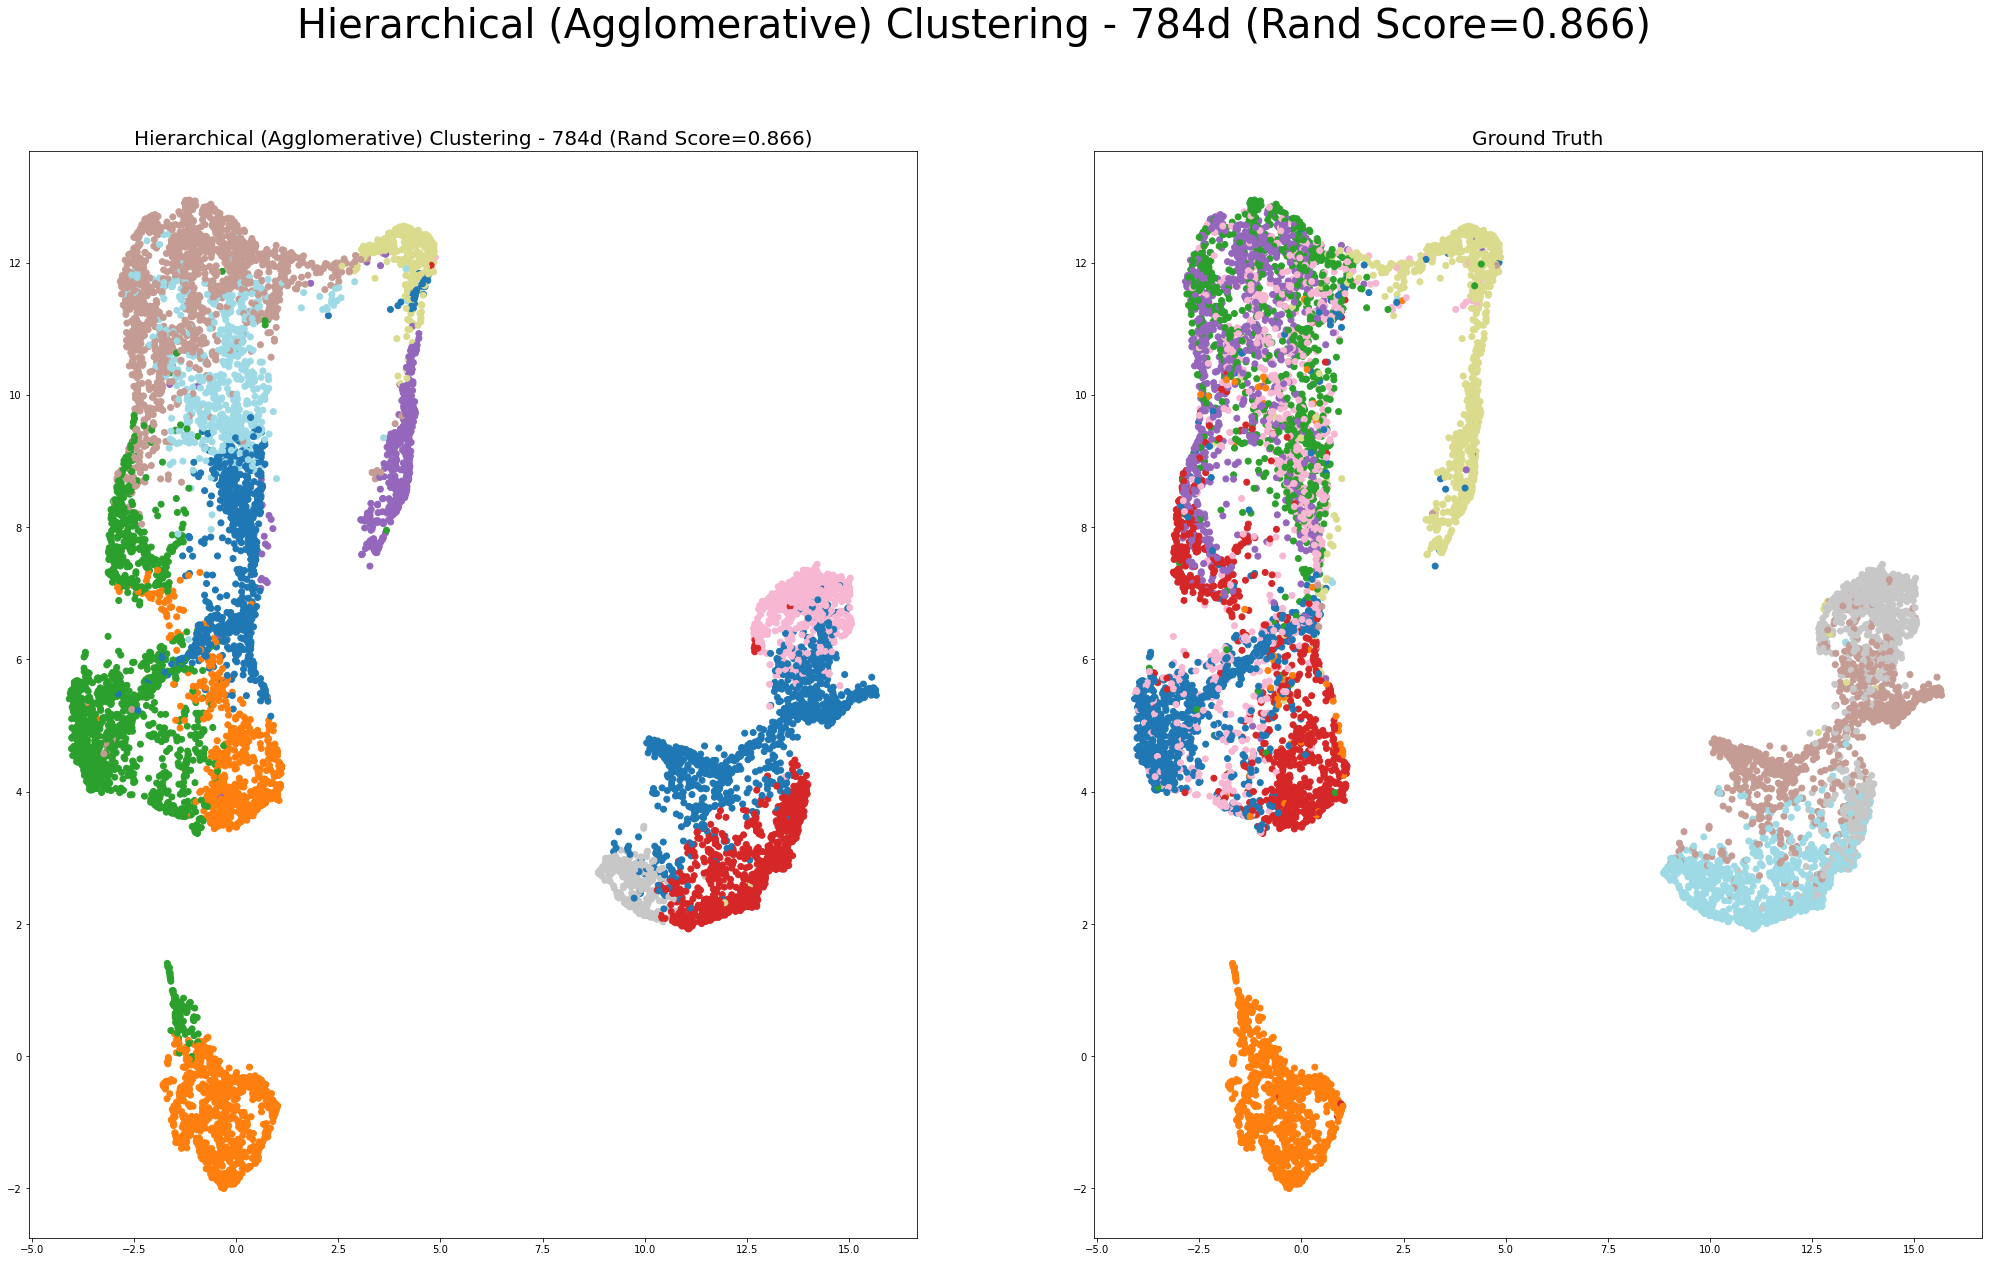

CPU times: total: 10.4 s
Wall time: 7.11 s


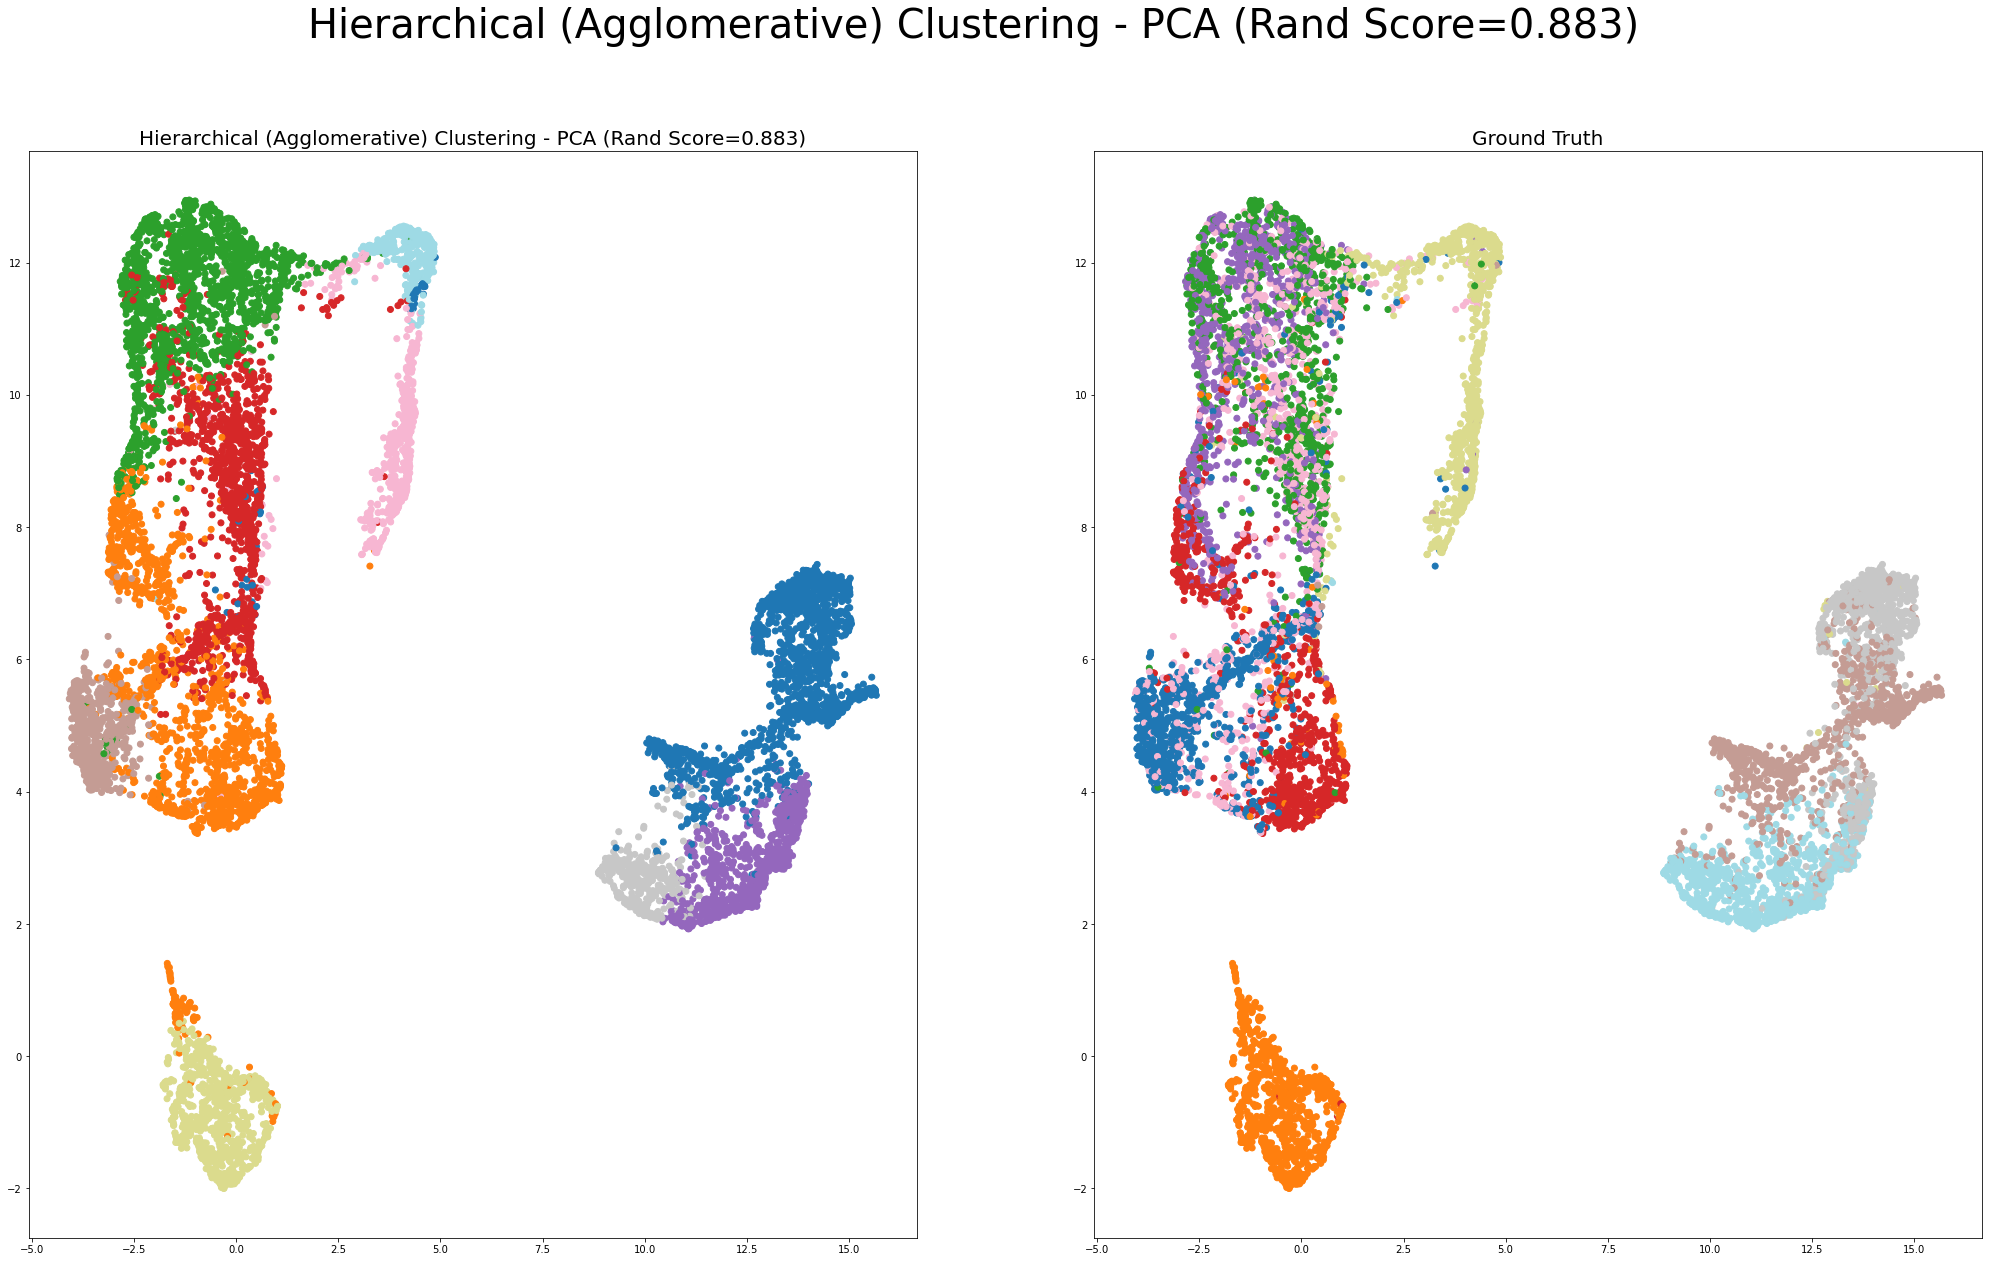

CPU times: total: 2.72 s
Wall time: 2.7 s


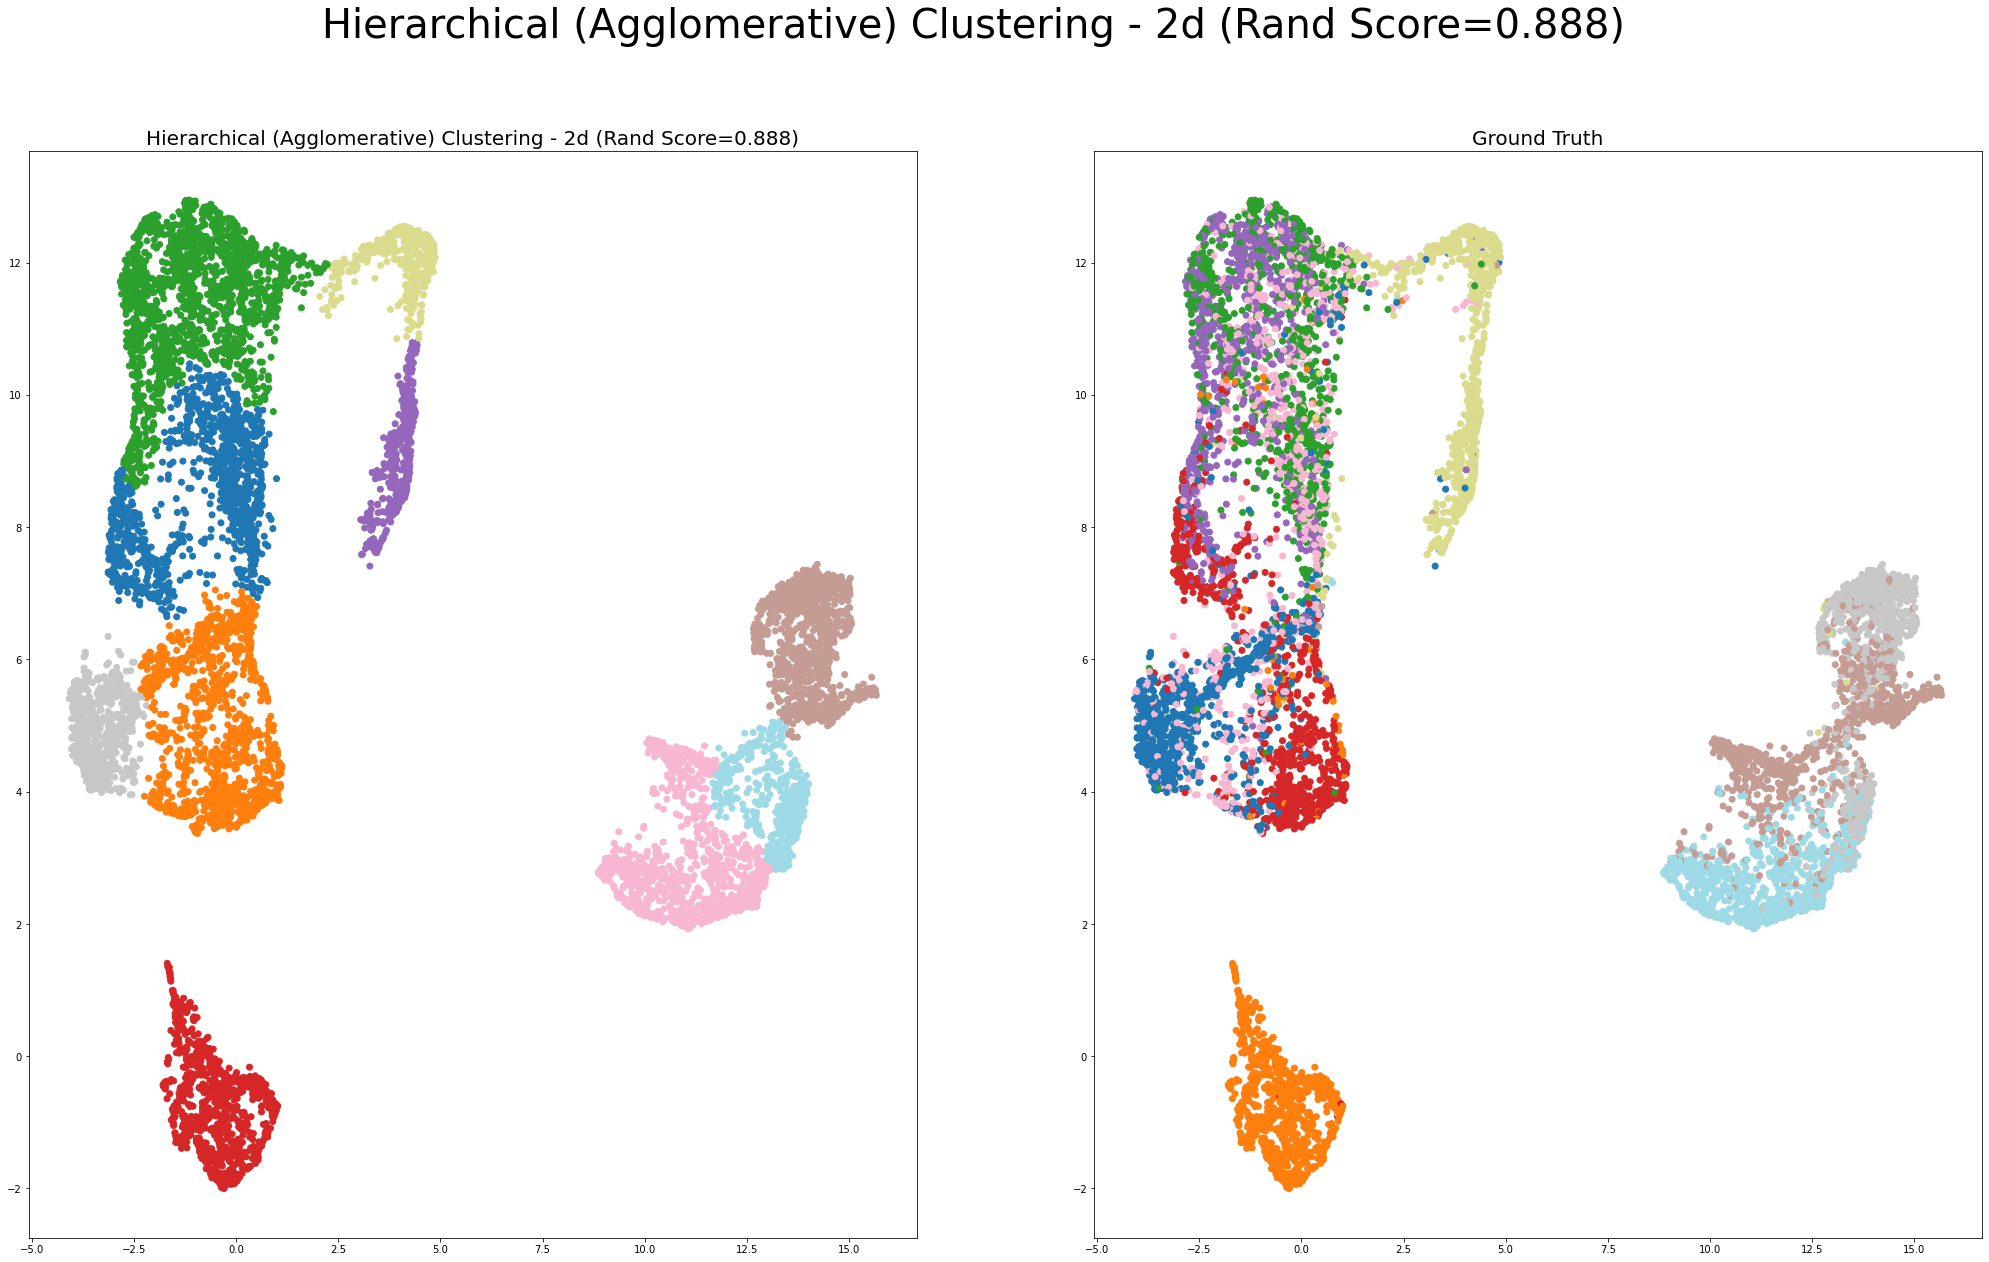

In [4]:
from sklearn.decomposition import PCA
%time clusters = AgglomerativeClustering(n_clusters=len(set(image_labels))).fit_predict(image_data)
score = metrics.rand_score(image_labels, clusters)
plot(
    plottable,
    image_labels,
    clusters,
    f"Hierarchical (Agglomerative) Clustering - 784d (Rand Score={score:.3f})"
)

%time clusters = AgglomerativeClustering(n_clusters=len(set(image_labels))).fit_predict(PCA(0.9).fit_transform(image_data))
score = metrics.rand_score(image_labels, clusters)
plot(
    plottable,
    image_labels,
    clusters,
    f"Hierarchical (Agglomerative) Clustering - PCA (Rand Score={score:.3f})"
)

%time clusters = AgglomerativeClustering(n_clusters=len(set(image_labels))).fit_predict(plottable)
score = metrics.rand_score(image_labels, clusters)
plot(
    plottable,
    image_labels,
    clusters,
    f"Hierarchical (Agglomerative) Clustering - 2d (Rand Score={score:.3f})"
)

And finally, HDBSCAN:

CPU times: total: 2min 10s
Wall time: 2min 10s
CPU times: total: 14.2 s
Wall time: 11.1 s
CPU times: total: 203 ms
Wall time: 198 ms


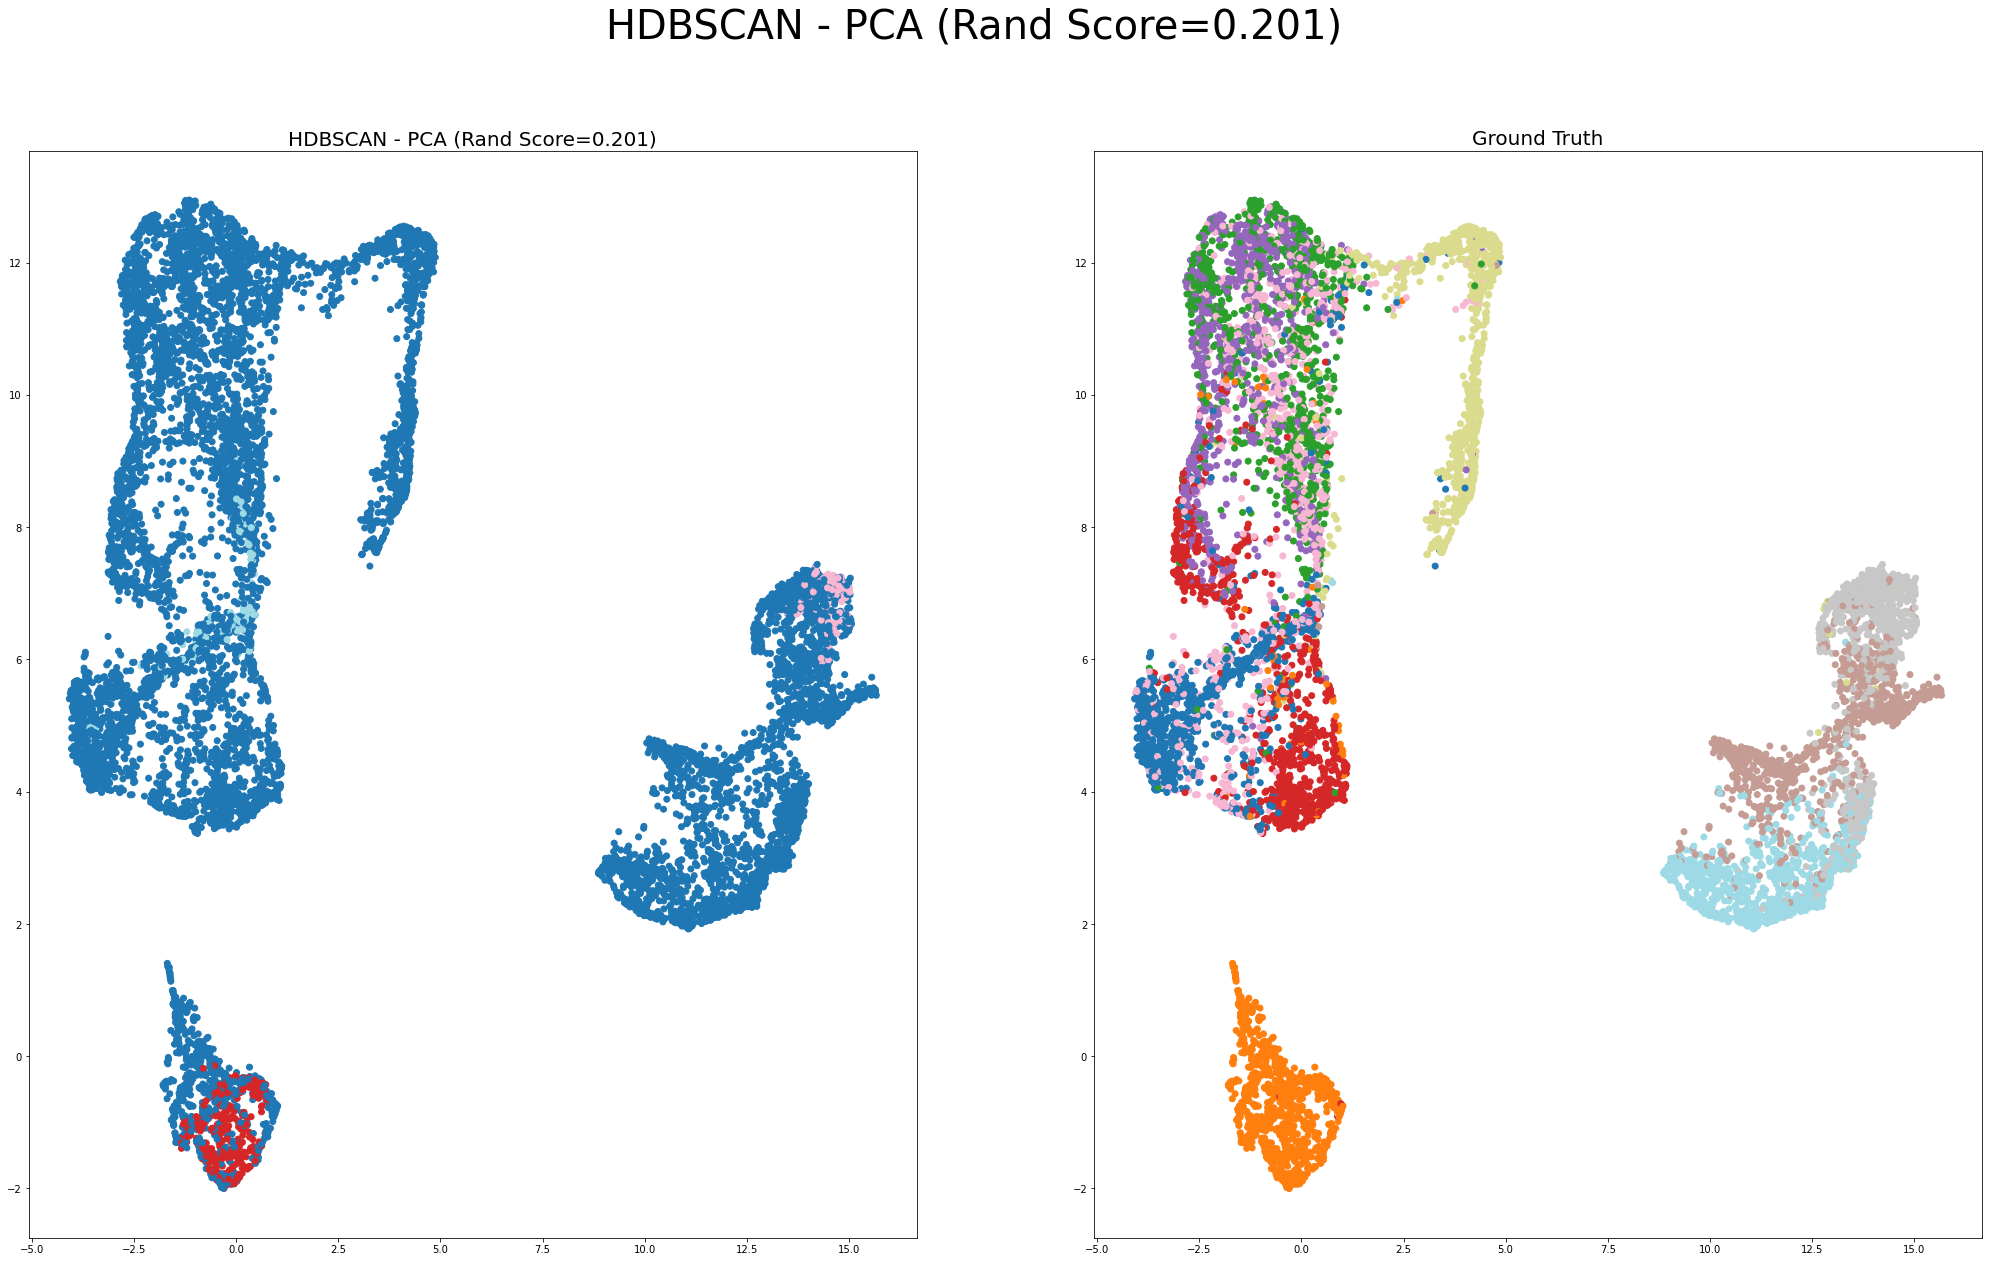

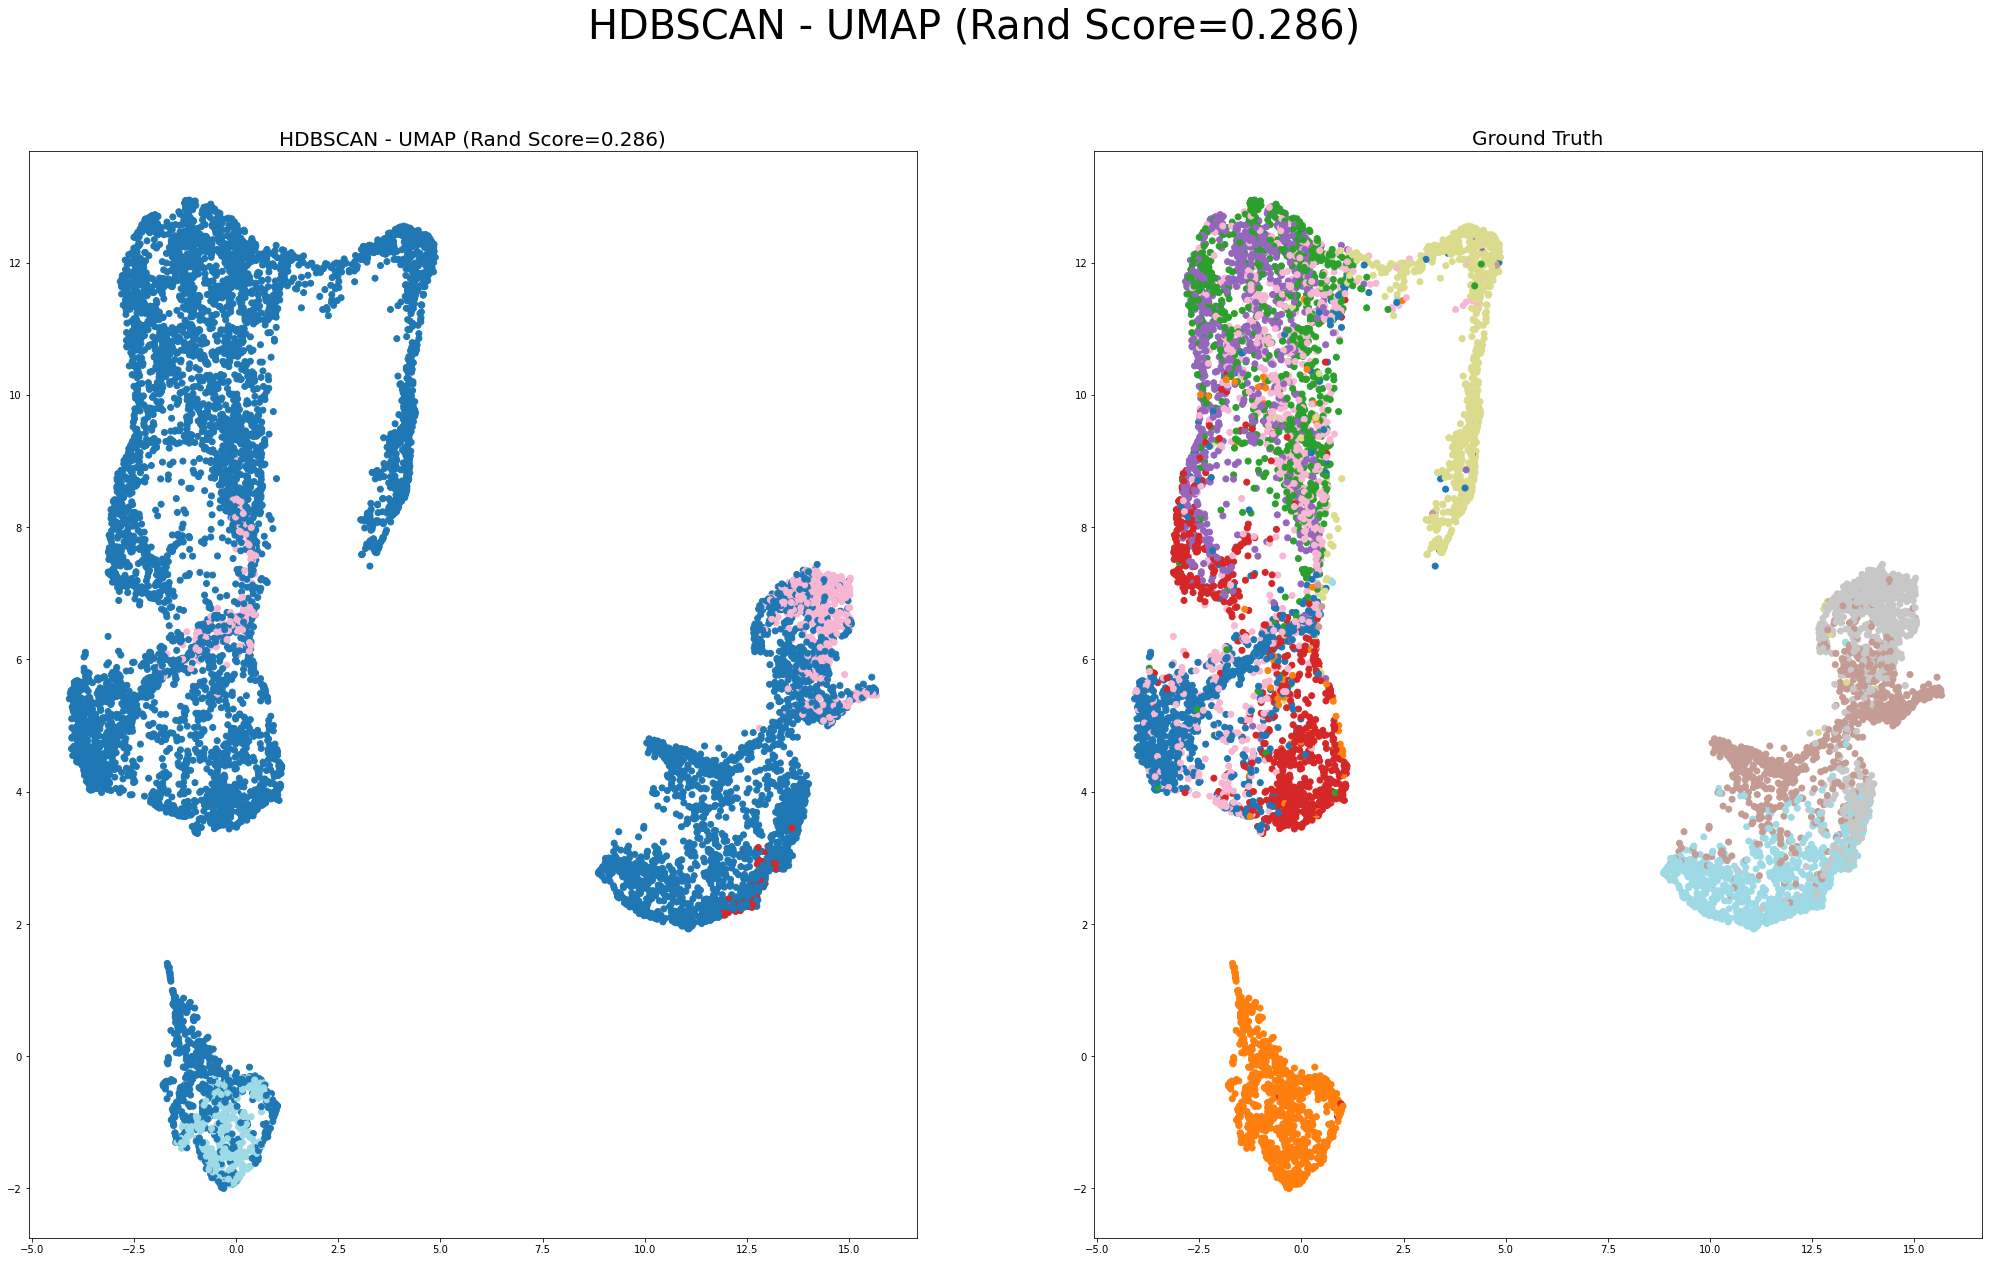

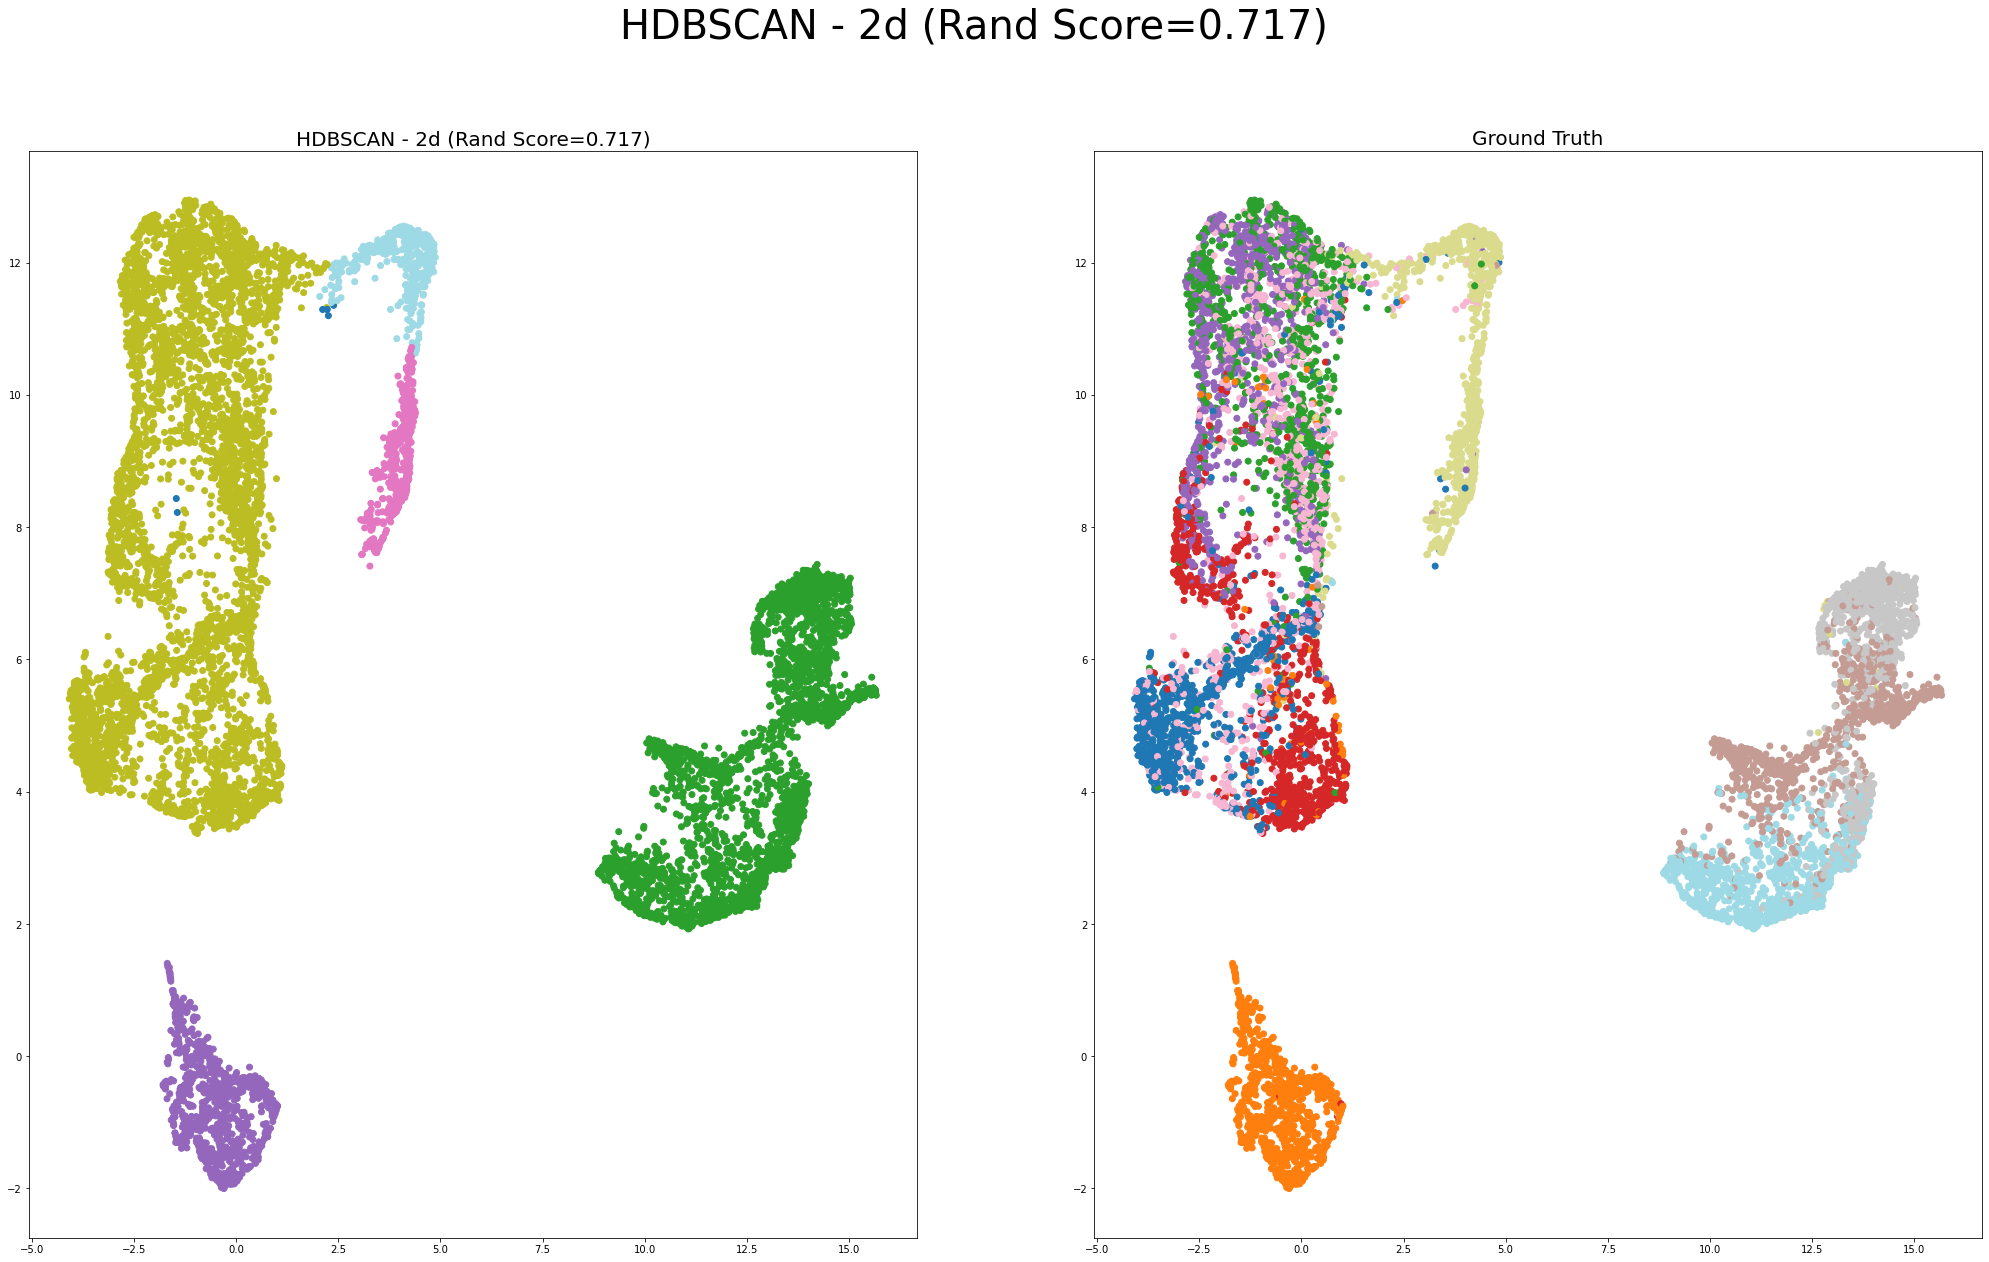

In [5]:
from sklearn.decomposition import PCA

%time hdbscan_784d = HDBSCAN(min_cluster_size=50).fit(image_data)
%time hdbscan_pca = HDBSCAN(min_cluster_size=50).fit(PCA(0.9).fit_transform(image_data))
%time hdbscan_2d = HDBSCAN(min_cluster_size=50).fit(plottable)

# Plain cluster plotting
plot(
    plottable,
    image_labels,
    hdbscan_784d.labels_,
    f"HDBSCAN - PCA (Rand Score={metrics.rand_score(image_labels, hdbscan_784d.labels_):.3f})",
)

plot(
    plottable,
    image_labels,
    hdbscan_pca.labels_,
    f"HDBSCAN - UMAP (Rand Score={metrics.rand_score(image_labels, hdbscan_pca.labels_):.3f})",
)

plot(
    plottable,
    image_labels,
    hdbscan_2d.labels_,
    f"HDBSCAN - 2d (Rand Score={metrics.rand_score(image_labels, hdbscan_2d.labels_):.3f})",
)

This behavior is actualy pretty typical for HDBSCAN, in my experience.  Very high-dimensional data tends to lump together into one big, hard-to-differentiate-without-labels blob, or it just looks like noise.  This is related to something called the *curse of dimensionality.*

Also, I was unable to get UMAP to pick out similar cluster structures to either the ground truth labels or to the other two algorithms.  This is not unusual.  K-Means and Agglomerative Clustering had to be told how many clusters to find, so we were able to guide them a bit; HDBSCAN does not let us input that sort of information.  But, I'd say that the clusters HDBSCAN found look very natural and sensible if we ignore the ground truth labels.

# Using clustering results

If you're using clusters to identify existing groups or structures in your data that you might later investigate, there aren't really any special tricks.  Run your cluster analysis of choice, configured in whatever way makes sense for your data, then treat the cluster results like category labels.  Within those categories you can analyse for differences among your features, or outcomes, or whatever.

# Exploring clustering algorithms a bit more

This time, I want to show how the different clustering algorithms deal with unseen points.  We'll use a very simple dataset here--a totally synthetic one consisting of three blobs of data in 2d.  We'll train K-Means and HDBSCAN, and see how they classify _all points in space_ (within a small and large radius around the data).  We won't use Hierarchical/Agglomerative Clustering, since there isn't really a way to predict new points from the model.  (this is a mathematical limitation of how the model is formulated, not a scikit-learn limitation).

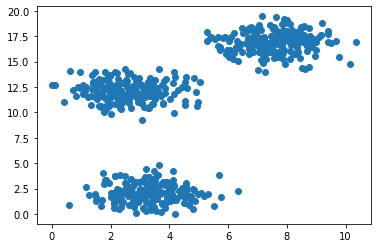

In [6]:
from sklearn.datasets import make_blobs
x, y = make_blobs(600, centers=[(0, 0), (5, 5), (0.5, -10)], random_state=0)
x = x - np.min(x, axis=0)
fig, ax = plt.subplots()
ax.scatter(x[:,0], x[:,1])
plt.show()

In [7]:
# function to plot predictions
def plot_cluster_predictions(
    data_points, data_clusters,
    near_points, near_clusters,
    far_points,  far_clusters,
):
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20,20))
    
    # Just the data points and their clusters
    ax[0,0].scatter(
        data_points[:,0],
        data_points[:,1],
        c=data_clusters,
        cmap="tab10",
    )
    ax[0,0].set_title("Predicted clusters for data points", fontsize=20)
    
    # Small neighborhood around the points and 
    ax[0,1].contourf(
        near_points[:,0].reshape(100, 100),
        near_points[:,1].reshape(100, 100),
        near_clusters.reshape(100, 100),
        alpha=0.5,
        cmap="tab10",
    )
    ax[0,1].scatter(
        data_points[:,0],
        data_points[:,1],
        c=data_clusters,
        cmap="tab10",
    )
    ax[0,1].set_title("Predicted clusters for near neighborhood", fontsize=20)
    
    # Areas very far away from the data points
    ax[1,0].contourf(
        far_points[:,0].reshape(1000, 1000),
        far_points[:,1].reshape(1000, 1000),
        far_clusters.reshape(1000, 1000),
        alpha=0.5,
        cmap="tab10",
    )
    ax[1,0].scatter(
        data_points[:,0],
        data_points[:,1],
        c=data_clusters,
        cmap="tab10",
    )
    ax[1,0].set_title("Predicted clusters for near neighborhood", fontsize=20)
    
    ax[1,1].set_axis_off()
    
    plt.show()    

In [8]:
# Near- and far-radius prediction data
near_xx, near_yy = np.meshgrid(
    np.linspace(np.min(x[:,0]) - 10, np.max(x[:,0]) + 10, 100),
    np.linspace(np.min(x[:,1]) - 10, np.max(x[:,1]) + 10, 100),
)
near_points = np.hstack((near_xx.reshape(-1, 1), near_yy.reshape(-1,1)))

far_xx, far_yy = np.meshgrid(
    np.linspace(np.min(x[:,0]) - 100, np.max(x[:,0]) + 100, 1000),
    np.linspace(np.min(x[:,1]) - 100, np.max(x[:,1]) + 100, 1000),
)
far_points = np.hstack((far_xx.reshape(-1, 1), far_yy.reshape(-1,1)))

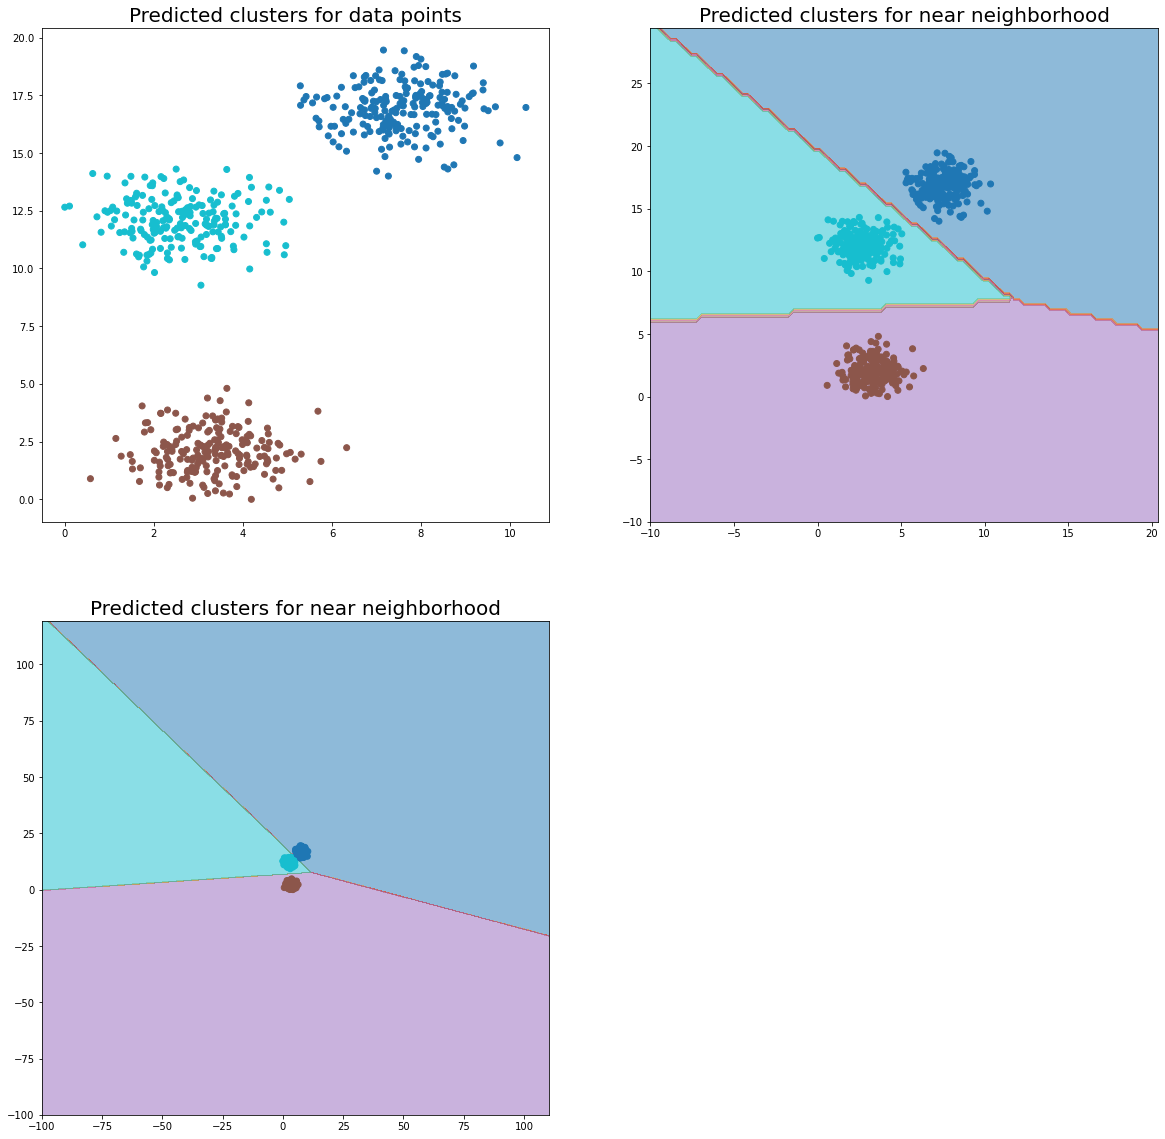

In [9]:
# K-Means
kmeans = KMeans(n_clusters=3).fit(x)
plot_cluster_predictions(
    x,
    kmeans.predict(x),
    near_points,
    kmeans.predict(near_points),
    far_points,
    kmeans.predict(far_points),
)

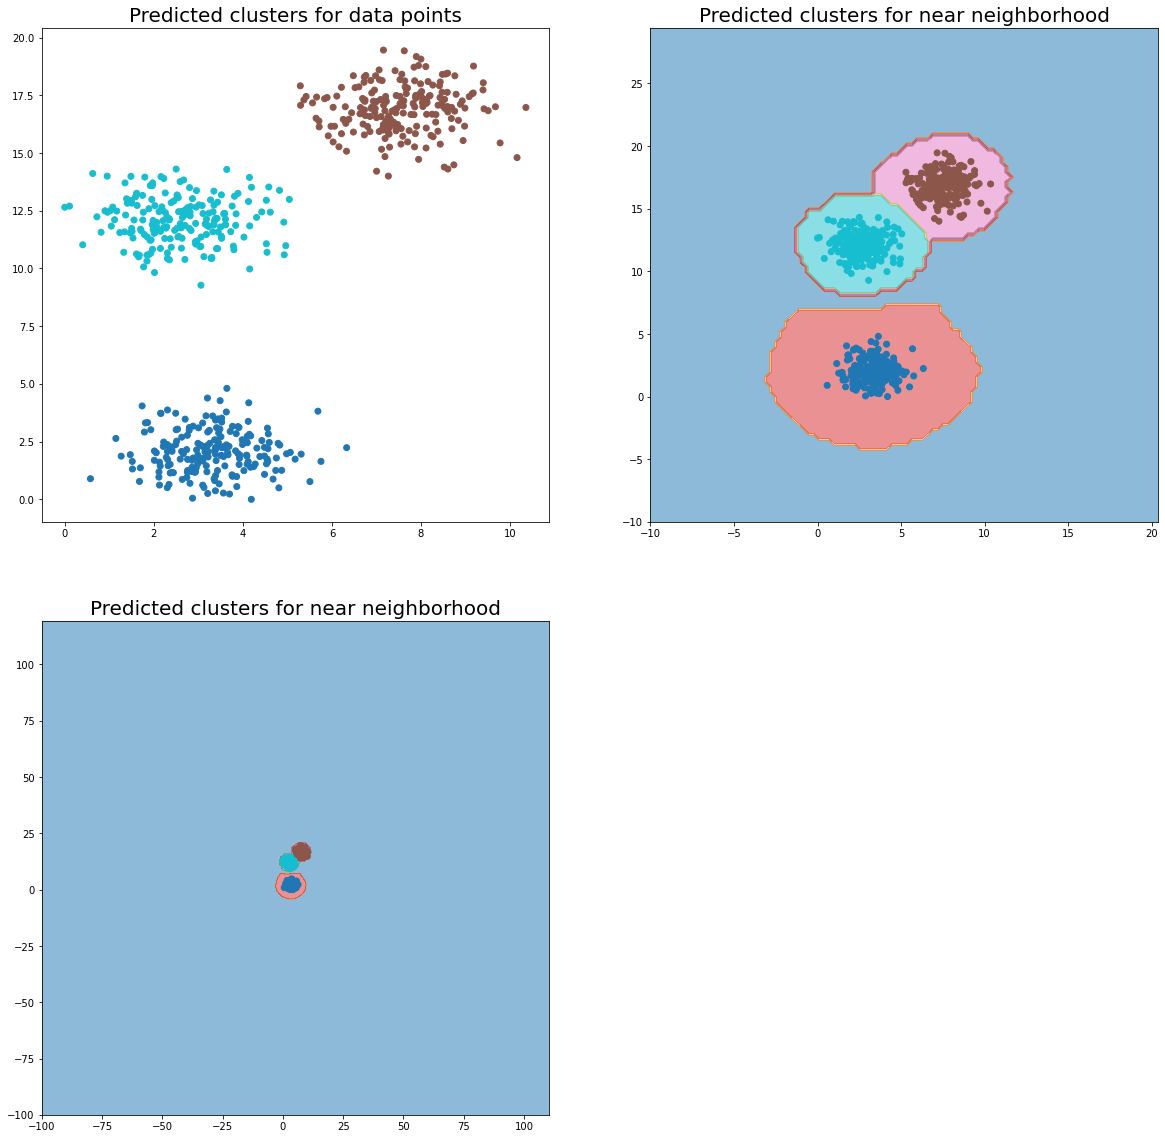

In [10]:
# HDBSCAN requires a few changes to predict on new data.  Namely:
# use `prediction_data=True`, and then import the approximate_predict
# function.  HDBSCAN is very much intended to be updated/retrained
# with new data, rather than used to generate predictions, so this
# is generally not preferred.  But it is possible.
from hdbscan.prediction import approximate_predict
hdbscan = HDBSCAN(prediction_data=True).fit(x)
data_clusters, data_probs = approximate_predict(hdbscan, x)
near_clusters, near_probs = approximate_predict(hdbscan, near_points)
far_clusters, far_probs = approximate_predict(hdbscan, far_points)

plot_cluster_predictions(
    x,
    data_clusters,
    near_points,
    near_clusters,
    far_points,
    far_clusters,
)